![image](https://user-images.githubusercontent.com/1651790/226242809-fe488ff2-bb4a-4e7d-b23a-70865a7b3228.png)

## Prepare Env

1. Install NebulaGraph with Docker Desktop

![](https://user-images.githubusercontent.com/1651790/241170277-e07e39d1-2b3a-486f-bb68-29a67bc3a714.png)

![](https://user-images.githubusercontent.com/1651790/241170258-3fca7e39-6e37-4ccb-8177-4771babb7b66.png)

2. Download Dataset

![](https://github.com/siwei-io/talks/assets/1651790/0c36cec3-87df-41a7-ad76-6eb4e59af5cf)

In [ ]:
# install ng_ai in the first run
%pip install ng_ai[networkx] matplotlib ipython-ngql

## AI Suite NetworkX Engine Examples
### read data with NetowrkX engine, query mode

In this example, we are leveraging the NetworkX Engine of NebulaGraph AI Suite, with the GraphD Query mode.

#### Step 1, get graph in Query Mode

We will scan all edge in type `follow` and `serve` first with props `degree` in `follow` and no props in `serve` as graph: `g`

player102 -> player100 (0): {'degree': 75}
player102 -> player101 (0): {'degree': 75}
player102 -> team203 (0): {}
player102 -> team204 (0): {}
player100 -> player101 (0): {'degree': 95}
player100 -> player125 (0): {'degree': 95}
player100 -> team204 (0): {}
player101 -> player100 (0): {'degree': 95}
player101 -> player102 (0): {'degree': 90}
player101 -> player125 (0): {'degree': 95}


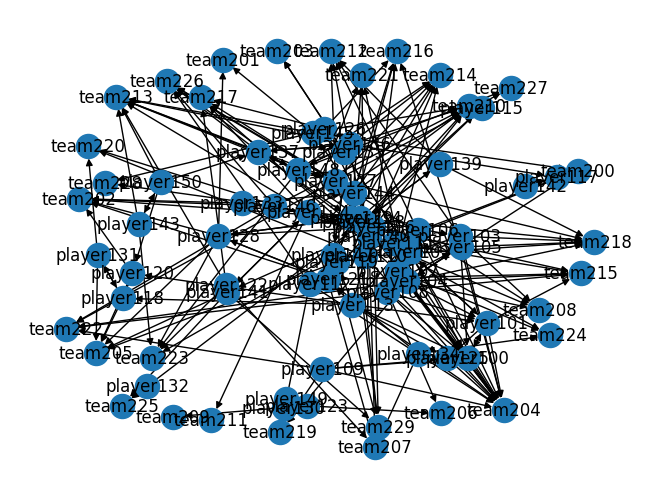

In [7]:
from ng_ai import NebulaReader
from ng_ai.config import NebulaGraphConfig

# read data with nebula/networkx engine, query mode
config_dict = {
    "graphd_hosts": "graphd:9669",
    "user": "root",
    "password": "nebula",
    "space": "demo_basketballplayer",
}
config = NebulaGraphConfig(**config_dict)
reader = NebulaReader(engine="nebula", config=config)
reader.query(edges=["follow", "serve"], props=[["degree"], []])
g = reader.read()
g.show(10)
g.draw()

#### Step 2, run Pagerank Algorithm

In [8]:
pr_result = g.algo.pagerank(reset_prob=0.15, max_iter=10)

#### Step 3, check results of the algorithm


In [9]:
pr_result

{'player102': 0.014742460872526248,
 'player100': 0.028860512684913252,
 'player101': 0.02024872139803953,
 'player129': 0.012512247226802331,
 'player116': 0.015356787485052367,
 'player121': 0.012446344735709932,
 'player128': 0.010478495284502901,
 'player138': 0.009227037520499495,
 'player115': 0.009402232824414627,
 'player139': 0.008062990891826879,
 'player114': 0.01102863347513255,
 'player103': 0.008281792309296297,
 'player140': 0.008281792309296297,
 'player150': 0.009480411569881077,
 'player120': 0.01352620851174098,
 'player137': 0.01192433644002994,
 'player143': 0.008957164521416133,
 'player104': 0.008581430586918268,
 'player105': 0.008097414576221332,
 'player107': 0.0069425503767085485,
 'player141': 0.0112819672832753,
 'player118': 0.014388747869242824,
 'player125': 0.020231625734755232,
 'player136': 0.012704094536560441,
 'player148': 0.01173044162350248,
 'player127': 0.008367006696325473,
 'player135': 0.0069425503767085485,
 'player147': 0.00848526597570543

### Write back algo result to NebulaGraph

Assume that we have a result `graph_result` computed with `g.algo.pagerank()`:

```python
{'player102': 0.014770646980811417,
 'player100': 0.02878478843123552,
 'player101': 0.020163880830622937,
 'player129': 0.012381302535422786,
 'player116': 0.015041184157101154,
 'player121': 0.012178909379871223,
 'player128': 0.010197889677928056,
...
}
```

Let's write them back to tag: pagerank(pagerank). So we create a TAG `pagerank` in NebulaGraph on same space with the following schema:

```ngql
CREATE TAG IF NOT EXISTS pagerank (
    pagerank double NOT NULL
);
```

Then, we could write the pagerank result to NebulaGraph, to tag `pagerank` with property `pagerank`:

```python
properties = ["pagerank"]
```
And pass it to NebulaWriter in `nebula` engine and `nebulagraph_vertex` sink

In [10]:
# Run pagerank Algorithm
graph_result = g.algo.pagerank()

In [6]:
from ng_ai import NebulaWriter

writer = NebulaWriter(
    data=graph_result,
    sink="nebulagraph_vertex",
    config=config,
    engine="nebula",
)

# properties to write
properties = ["pagerank"]

writer.set_options(
    tag="pagerank",
    properties=properties,
    batch_size=256,
    write_mode="insert",
)
# write back to NebulaGraph
writer.write()

In [14]:
# %pip install ipython-ngql

# Load extension
%load_ext ngql

In [19]:
%ngql --address graphd --port 9669 --user root --password nebula

Connection Pool Created


,Name
0,Apple_Vision_Pro
1,basketballplayer
2,demo_ai_ops
3,demo_basketballplayer
4,demo_data_lineage
5,demo_fifa_2022
6,demo_fraud_detection
7,demo_movie_recommendation
8,demo_sns
9,guardians


Then we could query the result in NebulaGraph:

```cypher
MATCH (v)
RETURN id(v), properties(v).name, v.pagerank.pagerank LIMIT 10;
```

In [20]:
%ngql USE basketballplayer;
%ngql MATCH (v) RETURN id(v), properties(v).name, v.pagerank.pagerank LIMIT 10;

,id(v),properties(v).name,v.pagerank.pagerank
0,player103,Rudy Gay,0.008311039669870448
1,player113,Dejounte Murray,0.006968969577862603
2,player121,Chris Paul,0.01217890937987122
3,player128,Carmelo Anthony,0.010197889677928056
4,player130,Joel Embiid,0.012120090423227127
5,player136,Steve Nash,0.012392730437200343
6,team205,Thunders,0.02425306502861434
7,team213,Mavericks,0.022814297437954496
8,team215,Hornets,0.016560356251094692
9,player127,Vince Carter,0.008183437103753102


In [22]:
%ngql MATCH p=()--() RETURN p LIMIT 100

,p
0,"(""team215"" :team{name: ""Hornets""} :pagerank{pa..."
1,"(""team215"" :team{name: ""Hornets""} :pagerank{pa..."
2,"(""team215"" :team{name: ""Hornets""} :pagerank{pa..."
3,"(""team215"" :team{name: ""Hornets""} :pagerank{pa..."
4,"(""team215"" :team{name: ""Hornets""} :pagerank{pa..."
...,...
95,"(""team227"" :team{name: ""Nets""} :pagerank{pager..."
96,"(""team227"" :team{name: ""Nets""} :pagerank{pager..."
97,"(""team210"" :team{name: ""Lakers""} :pagerank{pag..."
98,"(""team210"" :team{name: ""Lakers""} :pagerank{pag..."


In [23]:
%ng_draw

nebulagraph_draw.html


## Run multiple Algos and Draw the result

In [11]:
pr_result = g.algo.pagerank(reset_prob=0.15, max_iter=10)
louvain_result = g.algo.louvain()

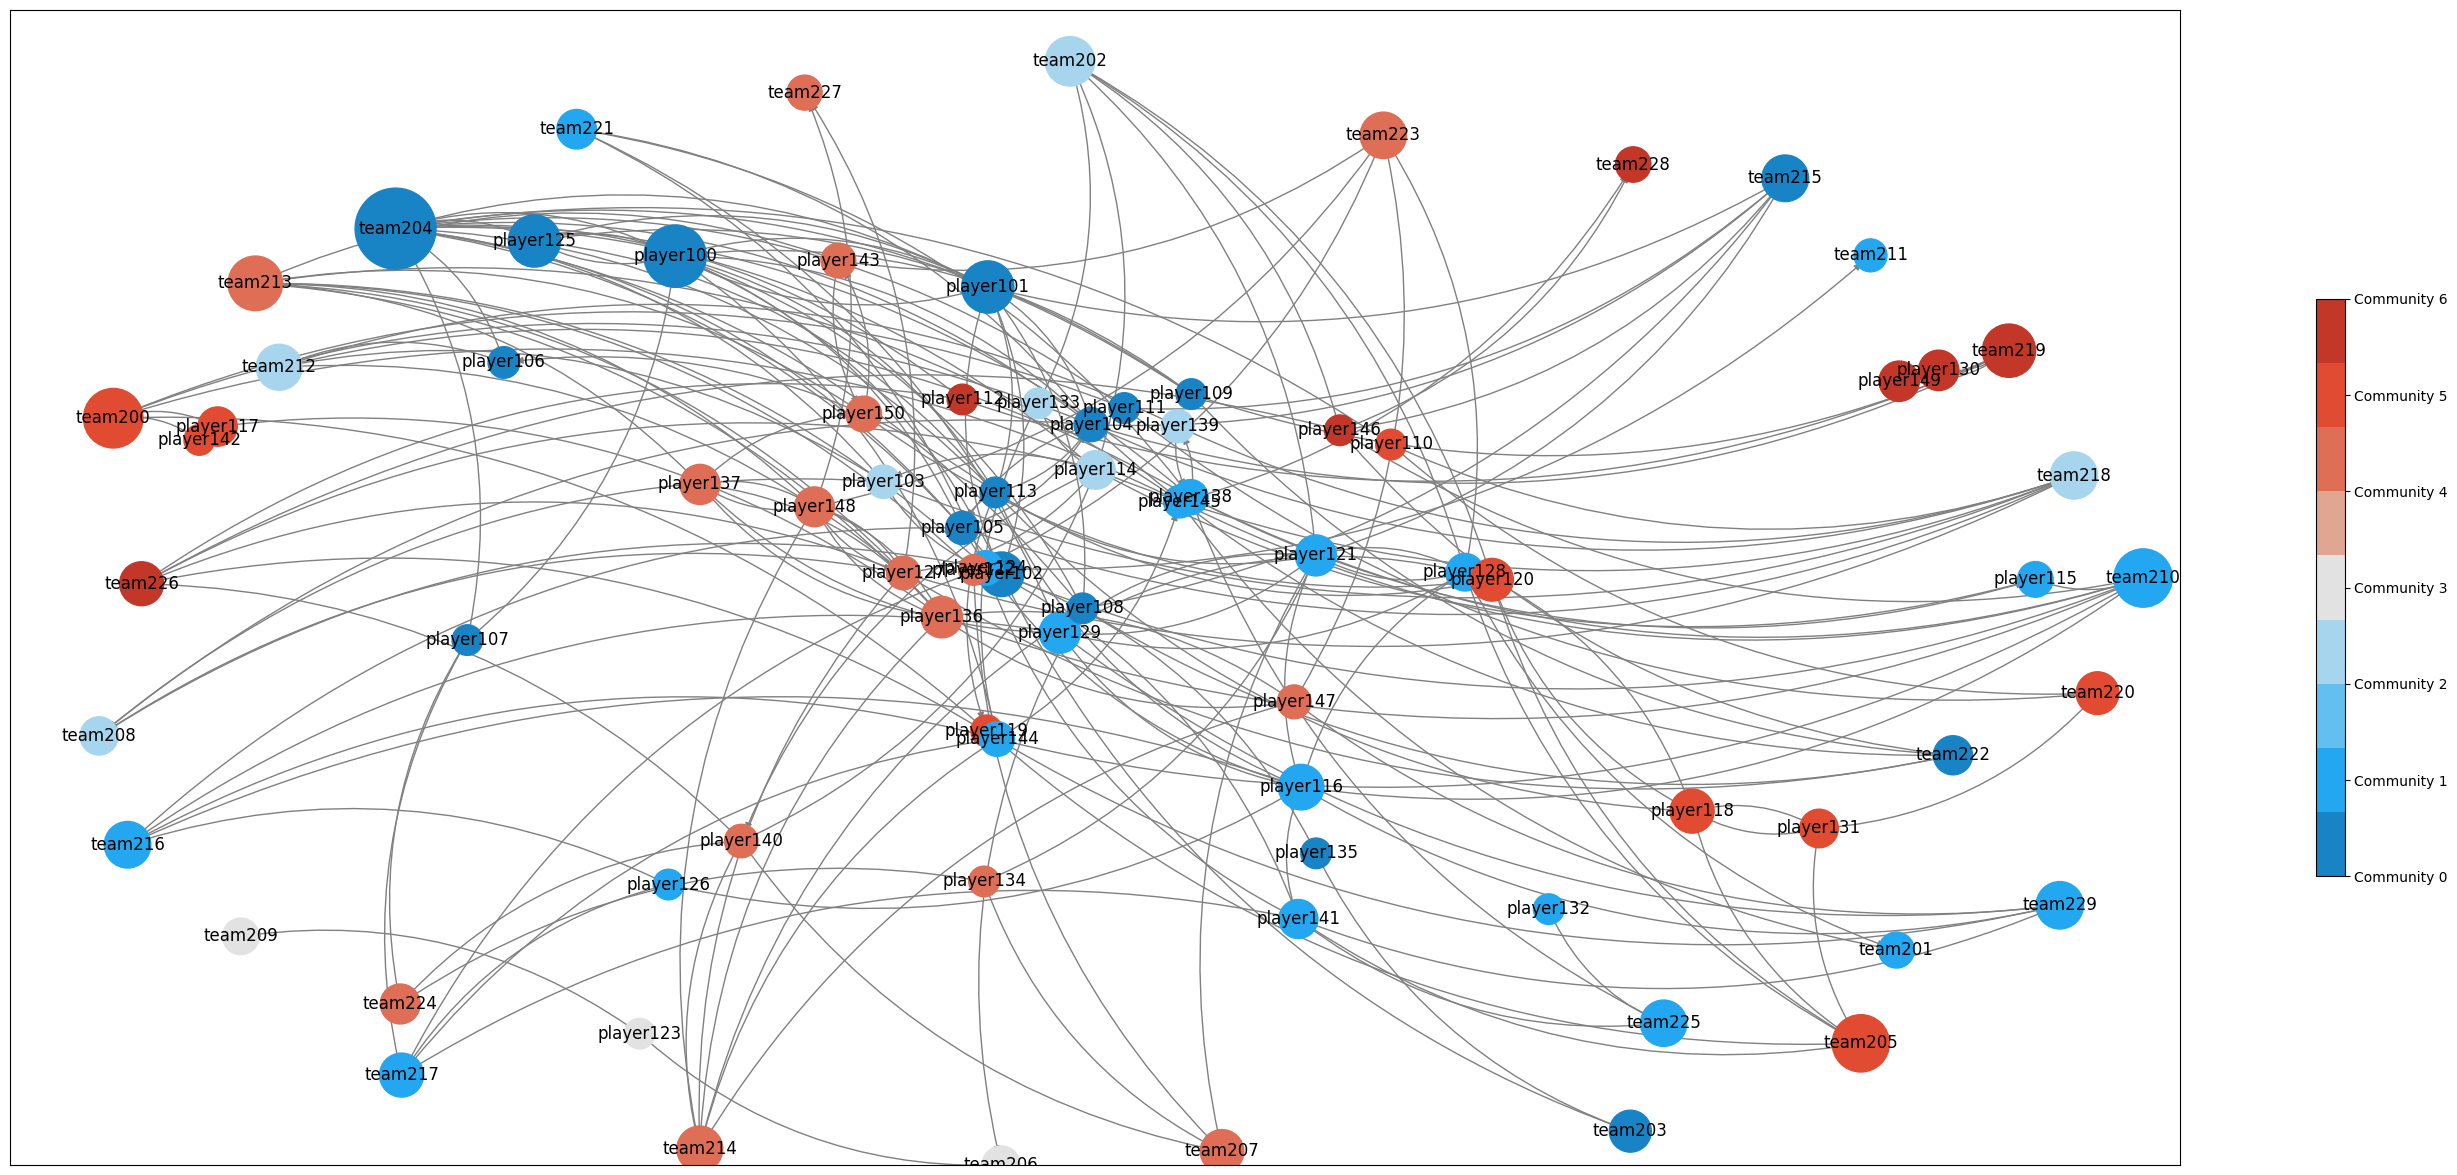

In [13]:
from matplotlib.colors import ListedColormap
G = g.data

import networkx as nx
import matplotlib.pyplot as plt
import random

def draw_graph_louvain_pr(G, pr_result, louvain_result, colors=["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]):
    # Define positions for the nodes
    pos = nx.spring_layout(G)

    # Create a figure and set the axis limits
    fig, ax = plt.subplots(figsize=(35, 15))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    # Create a colormap from the colors list
    cmap = ListedColormap(colors)

    # Draw the nodes and edges of the graph
    node_colors = [louvain_result[node] for node in G.nodes()]
    node_sizes = [70000 * pr_result[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_color=node_colors, node_size=node_sizes, cmap=cmap, vmin=0, vmax=max(louvain_result.values()))

    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='gray', width=1, connectionstyle='arc3, rad=0.2', arrowstyle='-|>', arrows=True)

    # Extract edge labels as a dictionary
    edge_labels = nx.get_edge_attributes(G, 'label')

    # Add edge labels to the graph
    for edge, label in edge_labels.items():
        ax.text((pos[edge[0]][0] + pos[edge[1]][0])/2,
                (pos[edge[0]][1] + pos[edge[1]][1])/2,
                label, fontsize=12, color='black', ha='center', va='center')

    # Add node labels to the graph
    node_labels = {n: G.nodes[n]['label'] if 'label' in G.nodes[n] else n for n in G.nodes()}
    nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=node_labels, font_size=12, font_color='black')

    # Add colorbar for community colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(louvain_result.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=range(max(louvain_result.values()) + 1), shrink=0.5)
    cbar.ax.set_yticklabels([f'Community {i}' for i in range(max(louvain_result.values()) + 1)])

    # Show the figure
    plt.show()


draw_graph_louvain_pr(G, pr_result=pr_result, louvain_result=louvain_result)